We have been worried about whether we can trust all changed records to come in the publishing profiles, as we have seen some troubling signs.  Recently, one of the programmers wrote a program that works as follows:

* Parse an update from the publishing profiles and make a list/set of all the bibs in the file.
* Open a file that contains "all records", and write those records to a new such file unless they appear 
  in the update file.
* Concatenate the update to the end of the new file.
* Rename the new file.

This gives us a way to use Python Data Analysis tools (pandas and jupyter notebooks) to analyze whether we are getting all the changed bibs or missing some.  The way we do this is by writing some custom code to extract a CSV from this `"alltime/bibs.mrc"` file and do the same for the output of an "Export Bibliographic Records" job in Alma.

The columns are:
* MMS Id
* leader[6:7] like "am"
* Our own unique identifier, NLM Unique ID, stored in 035 $9
* The 005 value

We will be joining based on the mms_id and using what SQL calls an "OUTER JOIN".

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta

Load CSV data produced by analysis of two MARC21 Binary outputs:
* The first was automatically created by Mark Vereb by progressively merging updates into a previous file.
* The second was produced by Alma by exporting bibliographic records from the set.

First, we need a function to import our format and convert some columns to the correct type.

In [2]:
def parse_allbibs(filename):
    dtypes = {
        'mms_id': object,
        'nlm_unique_id': object,
        'last_update': object,
    }
    frame = pd.read_csv(filename, dtype=dtypes)
    # convert the 005 to a datetime for later date clustering
    frame.last_update = pd.to_datetime(frame.last_update, format='%Y%m%d%H%M%S.0')
    # make the MMS_ID the index of the dataframe
    return frame.set_index(frame.mms_id).drop(columns=['mms_id'])

In [3]:
almabibs = parse_allbibs('allbibs-alma.csv')
almabibs

,biblevel,nlm_unique_id,last_update
mms_id,,,
9917000353406676,am,101700035,2021-06-08 04:14:50
9917000363406676,am,101700036,2021-06-08 04:14:47
9917000393406676,am,101700039,2021-06-08 04:15:04
9917000403406676,km,101700040,2021-06-08 04:15:00
9917000413406676,am,101700041,2021-06-08 04:15:03
...,...,...,...
997358393406676,am,9310145,2021-06-08 00:40:26
997358403406676,am,9310146,2021-06-08 00:40:51
997358413406676,am,9310147,2021-06-08 00:40:44


In [4]:
alltimebibs = parse_allbibs('allbibs-alltime.csv')
alltimebibs

,biblevel,nlm_unique_id,last_update
mms_id,,,
9918231200306676,am,9918231200306676,2021-07-22 15:04:47
9918231303406676,am,9918231303406676,2021-07-22 11:34:58
9918231091506676,am,9918231091506676,2021-07-22 12:38:21
9918231202606676,am,9918231202606676,2021-07-22 12:11:47
9918231303906676,am,9918231303906676,2021-07-22 09:41:23
...,...,...,...
9918185953406676,am,9918185953406676,2021-06-08 04:24:27
9918185843406676,am,9918185843406676,2021-06-08 04:24:49
993282713406676,am,36940500R,2021-06-07 20:08:27


In [5]:
allbibs = almabibs.join(alltimebibs, how='outer', lsuffix='_alma', rsuffix='_alltime')
allbibs

,biblevel_alma,nlm_unique_id_alma,last_update_alma,biblevel_alltime,nlm_unique_id_alltime,last_update_alltime
mms_id,,,,,,
9910000003406676,am,101000000,2021-06-08 02:04:15,am,101000000,2021-06-08 02:04:15
9910000013406676,aa,101000001,2021-06-08 02:04:18,aa,101000001,2021-06-08 02:04:18
9910000023406676,am,101000002,2021-06-08 02:03:59,am,101000002,2021-06-08 02:03:59
9910000033406676,aa,101000003,2021-06-08 02:04:06,aa,101000003,2021-06-08 02:04:06
991000003406676,as,0315655,2021-06-07 14:03:42,as,0315655,2021-06-07 14:03:42
...,...,...,...,...,...,...
999999953406676,am,100999995,2021-06-08 02:04:04,am,100999995,2021-06-08 02:04:04
999999963406676,aa,100999996,2021-06-08 02:04:21,aa,100999996,2021-06-08 02:04:21
999999973406676,aa,100999997,2021-06-08 02:04:14,aa,100999997,2021-06-08 02:04:14


Now we narrow down to focus just on the bibs where the 005 does not match.

In [6]:
diffs = allbibs[allbibs.last_update_alma != allbibs.last_update_alltime]
diffs

,biblevel_alma,nlm_unique_id_alma,last_update_alma,biblevel_alltime,nlm_unique_id_alltime,last_update_alltime
mms_id,,,,,,
9910017013406676,aa,101001701,2021-07-14 15:28:50,aa,101001701,2021-06-08 02:04:27
991037823406676,am,0326561,2021-07-14 15:31:00,am,0326561,2021-06-07 16:21:02
9910467523406676,aa,101046752,2021-07-14 15:54:21,aa,101046752,2021-06-08 02:40:27
9910467583406676,aa,101046758,2021-07-14 14:56:07,aa,101046758,2021-06-08 02:40:56
991047883406676,am,0330726,2021-07-14 15:58:36,am,0330726,2021-06-07 16:23:25
...,...,...,...,...,...,...
999622323406676,am,100962232,2021-07-14 15:57:08,am,100962232,2021-06-08 02:43:54
999714373406676,am,100971437,2021-07-14 15:37:56,am,100971437,2021-06-08 02:48:41
999716333406676,as,100971633,2021-07-14 15:27:06,as,100971633,2021-06-08 01:41:20


If the "nlm_unique_id" column from the CSV produced from the publishing profiles is NULL, that means that either the Publishing Profiles or our simple program to concatenate the update files missed these bibs entirely.

In [7]:
diffs[diffs.nlm_unique_id_alltime.isnull()]

,biblevel_alma,nlm_unique_id_alma,last_update_alma,biblevel_alltime,nlm_unique_id_alltime,last_update_alltime
mms_id,,,,,,
9918205367306676,am,9918205367306676,2021-07-09 13:48:23,NaN,NaN,NaT
9918205367406676,am,9918205367406676,2021-07-09 13:48:26,NaN,NaN,NaT
9918205367506676,am,9918205367506676,2021-07-09 13:48:28,NaN,NaN,NaT
9918205367606676,am,9918205367606676,2021-07-09 13:48:27,NaN,NaN,NaT
9918205367706676,am,9918205367706676,2021-07-09 13:48:25,NaN,NaN,NaT
...,...,...,...,...,...,...
9918226080406676,am,9918226080406676,2021-06-15 09:45:50,NaN,NaN,NaT
9918226080506676,am,9918226080506676,2021-06-14 12:52:43,NaN,NaN,NaT
9918226080806676,am,9918226080806676,2021-06-15 14:00:27,NaN,NaN,NaT


So, 108 records do not appear in the merged `"alltime/bibs.mrc"`.  Likely the cause is (a) a missed file that we did get from Alma, or (b) Alma missed the records. This is not a lot.

Next we look and see whether the "last_update" column (or 005 value) from the CSV produced from an Alma export is NULL.  This means that our `"alltime/bibs.mrc"` contains a bib that is no longer present in Alma, and this could easily mean that we are not processing deleted records, or that the publishing profile failed to detect one or more deleted records.

In [8]:
diffs[diffs.last_update_alma.isnull()]

,biblevel_alma,nlm_unique_id_alma,last_update_alma,biblevel_alltime,nlm_unique_id_alltime,last_update_alltime
mms_id,,,,,,
9917593763406676,NaN,NaN,NaT,am,101759376,2021-06-08 04:34:56
9917780553406676,NaN,NaN,NaT,gm,101778055,2021-06-08 04:09:36
9917781133406676,NaN,NaN,NaT,gm,101778113,2021-06-08 04:09:36
9918231199406676,NaN,NaN,NaT,am,9918231199406676,2021-07-22 17:26:39
9918231199506676,NaN,NaN,NaT,am,9918231199506676,2021-07-22 15:27:08


5 records appear in the `"alltime/bibs.mrc"` but are not in Alma at the present time. We assume this is our program, and is such a small number we aren't going to follow up right now.

Next, we look at records that appear in both CSVs - these validate our alltime process as most records match, and imply that we are not getting all records that we modify in the publishing profiles.

In [9]:
mismatch_uptimes = diffs[diffs.last_update_alma.notnull() & diffs.last_update_alltime.notnull()]
mismatch_uptimes

,biblevel_alma,nlm_unique_id_alma,last_update_alma,biblevel_alltime,nlm_unique_id_alltime,last_update_alltime
mms_id,,,,,,
9910017013406676,aa,101001701,2021-07-14 15:28:50,aa,101001701,2021-06-08 02:04:27
991037823406676,am,0326561,2021-07-14 15:31:00,am,0326561,2021-06-07 16:21:02
9910467523406676,aa,101046752,2021-07-14 15:54:21,aa,101046752,2021-06-08 02:40:27
9910467583406676,aa,101046758,2021-07-14 14:56:07,aa,101046758,2021-06-08 02:40:56
991047883406676,am,0330726,2021-07-14 15:58:36,am,0330726,2021-06-07 16:23:25
...,...,...,...,...,...,...
999622323406676,am,100962232,2021-07-14 15:57:08,am,100962232,2021-06-08 02:43:54
999714373406676,am,100971437,2021-07-14 15:37:56,am,100971437,2021-06-08 02:48:41
999716333406676,as,100971633,2021-07-14 15:27:06,as,100971633,2021-06-08 01:41:20


1297 records have different last update times, indicating perhaps that some records were left out of the publishing profiles.

Let's make the last update (or 005 value) from Alma an index, convert that index in such a way as to "group" by business day and count the "mms_id" values.

<AxesSubplot:xlabel='last_update_alma'>

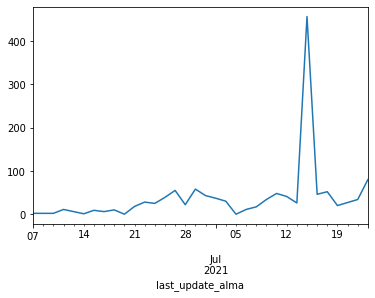

In [10]:
mismatch_count_byday = mismatch_uptimes.reset_index().set_index('last_update_alma').resample('B')['mms_id'].count()
mismatch_count_byday.plot()

We see that there are records from each business day that are left out. Since we have something to plot, let's do a better job of presenting it.

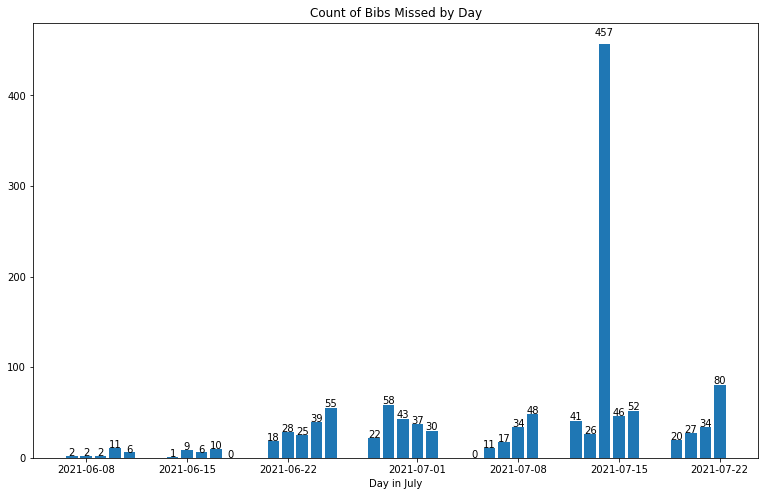

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(13, 8))
rect = plt.bar(x=mismatch_count_byday.index, height=mismatch_count_byday, width=0.8)
for i, count in enumerate(mismatch_count_byday):
    patch = rect.patches[i]
    width = patch.get_width()
    height = patch.get_height()
    x, y = patch.get_xy()
    ax.annotate(f'{count:d}', (x + width/2, y + height*1.02), ha='center')
ax.set_xlabel('Day in July')
title = ax.set_title('Count of Bibs Missed by Day')